Overview: This project is intended to test the suitability of Online Machine Learning techniques to problems with drifting parameters. In particular, I will be trying to predict the parameters theta for some multiple linear regression problem, where the parameters theta will be deviated slightly at each timestep.

Problem: At every timestep, a new set of observations (X, y) is created, where y = X * theta for some theta.

Model: y = X * theta

Loss/Error function: sum((theta - theta_hat)^2), where theta_hat is the predicted value of theta

In [1]:
import numpy as np
import math

The Generator class generates new observations for X and y, and controls the movement of the hidden parameter theta
The deviation is taken from (n+1) * U ^ n, where U is uniformly distributed on [0, 1], and n >= 0. This distribution has a mean of 1. This is then scaled by the value of drift.

In [2]:
class Generator:
    def __init__(self,          
                 Xdims, #number of independent variables
                 ydims, #number of dependent variables
                 drift=0.05, #average distance of movement
                 sharpness=1, #sporadicity of movement
                 noise=0, #magnitude of randomness of y
                 width=3 #interval on which theta is randomly initialised about 0
                ): 
        
        self.Xdims = Xdims
        self.ydims = ydims
        self.drift = drift
        self.sharpness = sharpness
        self.noise = noise
        
        self.theta = width*(2*np.matrix(np.random.rand(Xdims+1, ydims)-1)/math.sqrt(Xdims * ydims))
        
    def generate(self, observations=1):
        X = np.matrix(np.random.rand(observations, self.Xdims))
        
        X_ = np.matrix(np.ones((observations, self.Xdims+1)))
        X_[:,:-1] = X
        
        y = X_ * self.theta
        y = y
        return X, y
    
    def deviate(self):
        unit_move = np.random.randn(self.Xdims+1, self.ydims)
        unit_move = unit_move/ np.linalg.norm(unit_move)
        
        move = unit_move * self.drift * (self.sharpness + 1) * np.random.rand(1) ** self.sharpness
        self.theta = self.theta + move

In [3]:
G = Generator(4, 2)
G.generate()

(matrix([[ 0.86736378,  0.9249692 ,  0.17674629,  0.28203144]]),
 matrix([[-3.44229132, -4.56234863]]))

The OnlineMLRegressor class uses stochastic gradient descent to attempt to predict theta.

In [4]:
class OnlineMLRegressor:
    def __init__(self, Xdims, ydims, learning_rate=0.1):
        self.Xdims = Xdims
        self.ydims = ydims
        self.learning_rate = learning_rate
        
        self.theta = np.matrix(np.random.rand(Xdims+1, ydims)/math.sqrt(Xdims * ydims))
        
    def learn(self, X, y):
        X_ = np.matrix(np.ones((np.shape(X)[0], self.Xdims+1)))
        X_[:,:-1] = X
        
        delta_y = (y - X_ * self.theta)
        grad_theta = X_.transpose() * delta_y
        self.theta = self.theta + self.learning_rate * grad_theta / np.shape(X)[0]  

The loss that I will be measuring is the mean squared Frobenius norm, or matrix norm, of theta and theta_hat. This is just the mean squared difference between all entries

In [5]:
def MSE(x, y):
    return np.linalg.norm(x - y)**2/np.prod(np.size(x))

To test each learning rate, I will run the model for several iterations, recording the loss at each iteration, to check for stability and rate of convergence. I will be testing in the case of 3 independent variables and 1 dependent variable.

In [6]:
def test1(lr, iterations, dr=0.05, sharp=1, verbose=False, sigma=0.1):
    G = Generator(3, 1, drift=dr, sharpness=sharp, noise=sigma)
    O = OnlineMLRegressor(3, 1, learning_rate=lr)
    vals = []
    for i in range(iterations):
        X, y = G.generate()
        O.learn(X,y)
        vals.append(MSE(G.theta, O.theta))
        if (i+1) % 100 == 0 and verbose:
            print("error after",i+1,"timesteps:", MSE(G.theta, O.theta))       
        G.deviate()
        
    return vals

vals = test1(0.1, 1000, verbose=True)

error after 100 timesteps: 0.616917430357
error after 200 timesteps: 0.328456716726
error after 300 timesteps: 0.0898530461288
error after 400 timesteps: 0.0364594926066
error after 500 timesteps: 0.0166332743436
error after 600 timesteps: 0.00643778387061
error after 700 timesteps: 0.0655715317313
error after 800 timesteps: 0.0670540427359
error after 900 timesteps: 0.0610018711972
error after 1000 timesteps: 0.0218399840548


I can alter the test parameters below to compare learning rates for different drift conditions.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

learning_rates = (0.01, 0.03, 0.1, 0.3, 0.5, 1)
sharpness = 5
drift = 0.05
iters = 5000

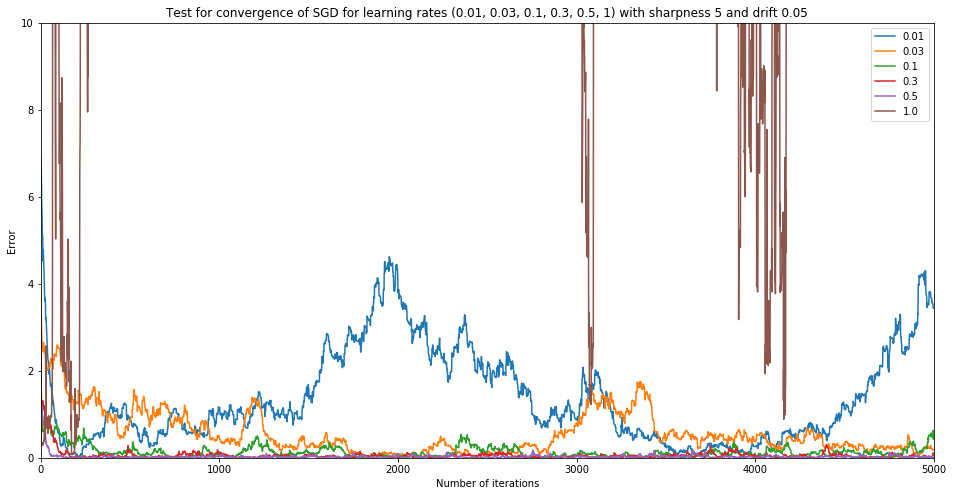

In [8]:
frames = []

for i in learning_rates:
    vals = pd.DataFrame(test1(i, dr=drift, sharp=sharpness, iterations=iters, sigma=0.5))
    vals.columns = [i]                        
    frames.append(vals)
      
df = pd.concat(frames, axis=1)
df.plot(figsize=(16,8))

plt.xlim([0,iters])
plt.ylim([0,10])
plt.title("Test for convergence of SGD for learning rates " + repr(learning_rates) + " with sharpness " + str(sharpness) + " and drift " + str(drift))
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.show()

The error terms can be on vastly different scales, so below I have instead taken log-error rather than just error to visualise error results.

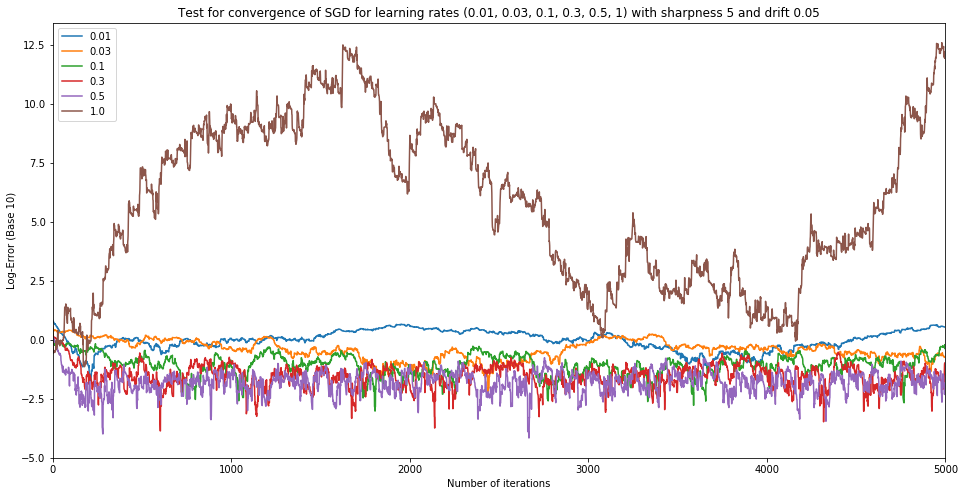

In [9]:
(np.log(df)/math.log(10)).plot(figsize=(16,8))
plt.title("Test for convergence of SGD for learning rates " + repr(learning_rates) + " with sharpness " + str(sharpness) + " and drift " + str(drift))
plt.xlabel("Number of iterations")
plt.ylabel("Log-Error (Base 10)")
plt.xlim([0,iters])
plt.show()

By adjusting the parameters of sharpness and drift, it is clear that the ideal learning rate is highly dependent on how much the parameter moves at each timestep and how varied these movements are. However for most of these runs, it is evident that a learning rate too small makes convergence really slow, if it converges at all, and learning rates that are too high cause the algorithm to be divergent. Divergent behaviour was observed frequently for learning rate 1 in certain conditions, for example at sharpness 5 and drift 0.05.

I will now attempt to perform Online ML with recall; instead of performing stochastic gradient descent on the most recent example, it will perform batch gradient descent on a set number of the most recent observations. I will perform this on examples of 3 independent variables and 1 dependent variable, with recall of 10, 100 and 1000 observations.

In [10]:
def test2(lr, iterations, recall=5, dr=0.05, sharp=1, verbose=False, sigma=0.1):
    G = Generator(3, 1, drift=dr, sharpness=sharp, noise=sigma)
    O = OnlineMLRegressor(3, 1, learning_rate=lr)
    vals = []
    
    cum_X = np.matrix([])
    cum_y = np.matrix([])
    for i in range(iterations):
        X, y = G.generate()
        
        if i != 0:
            cum_X = np.concatenate((cum_X, X), axis=0)[-recall:,:]
            cum_y = np.concatenate((cum_y, y), axis=0)[-recall:,:]
        else:
            cum_X = X
            cum_y = y
            
        O.learn(cum_X,cum_y)
        vals.append(MSE(G.theta, O.theta))
        if (i+1) % 100 == 0 and verbose:
            print("error after",i+1,"timesteps:", MSE(G.theta, O.theta))       
        G.deviate()
        
    return vals

vals = test2(0.1, 1000, verbose=True)

error after 100 timesteps: 0.0873192336513
error after 200 timesteps: 0.0914655378872
error after 300 timesteps: 0.0603902175301
error after 400 timesteps: 0.100443394556
error after 500 timesteps: 0.0187943659689
error after 600 timesteps: 0.0597967226744
error after 700 timesteps: 0.122621311779
error after 800 timesteps: 0.0174323186788
error after 900 timesteps: 0.0184010891129
error after 1000 timesteps: 0.0869622073216


In [11]:
def recall_test(rc):
    frames = []
    for i in learning_rates:
        vals = pd.DataFrame(test2(i, dr=drift, sharp=sharpness, recall=rc, iterations=iters, sigma=0.5))
        vals.columns = [i]                        
        frames.append(vals)

    df = pd.concat(frames, axis=1)
    df.plot(figsize=(14,7))

    plt.xlim([0,iters])
    plt.ylim([0,5])
    plt.title("Test for convergence of BGD with recall for learning rates " + repr(learning_rates) +
              " with sharpness " + str(sharpness) + ", drift " + str(drift) + " and recall " + str(rc))
    plt.xlabel("Number of iterations")
    plt.ylabel("Error")
    plt.show()

    (np.log(df)/math.log(10)).plot(figsize=(14,7))
    plt.title("Test for convergence of BGD with recall for learning rates " + repr(learning_rates) +
              " with sharpness " + str(sharpness) + ", drift " + str(drift) + " and recall " + str(rc))
    plt.xlabel("Number of iterations")
    plt.ylabel("Log-Error (Base 10)")
    plt.xlim([0,iters])
    plt.show()

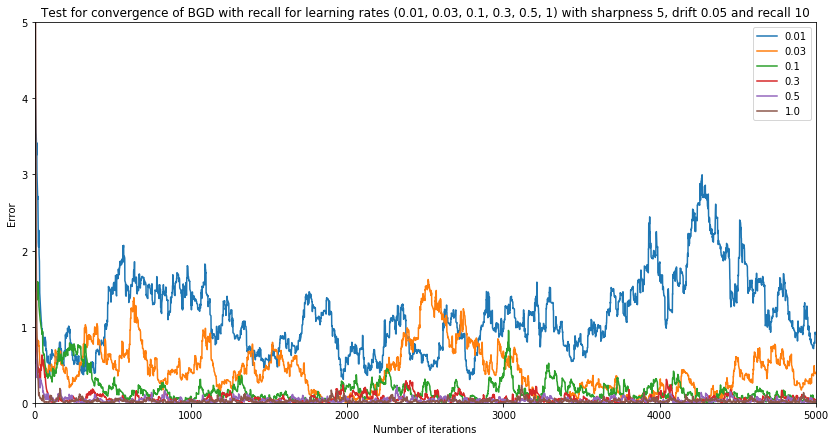

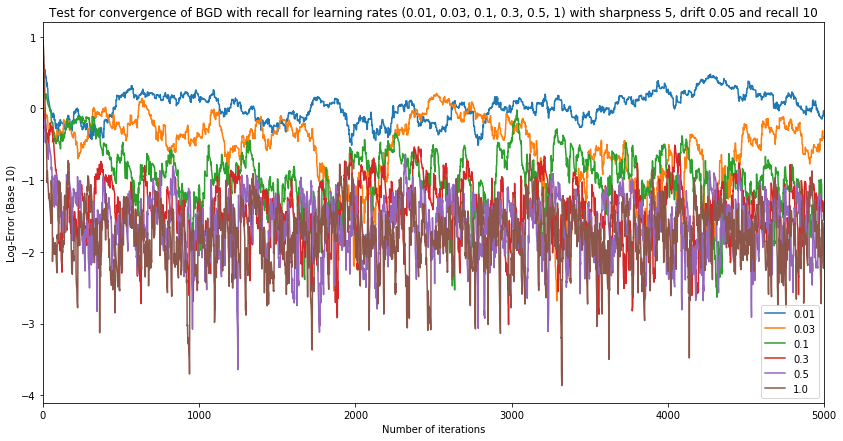

In [12]:
recall_test(10)

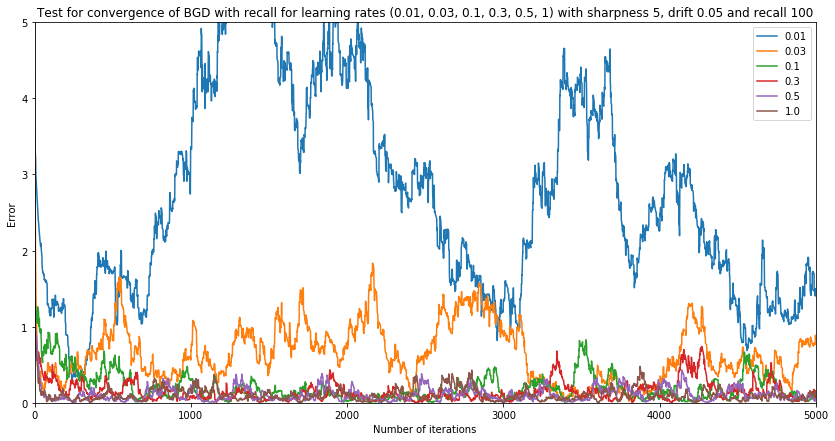

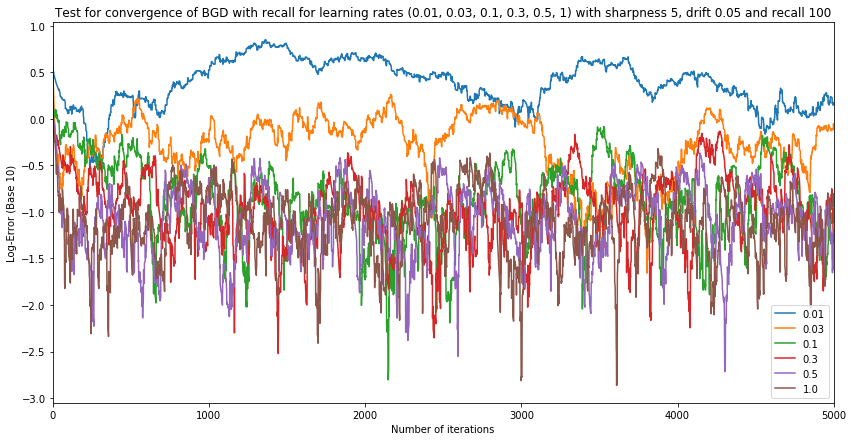

In [13]:
recall_test(100)

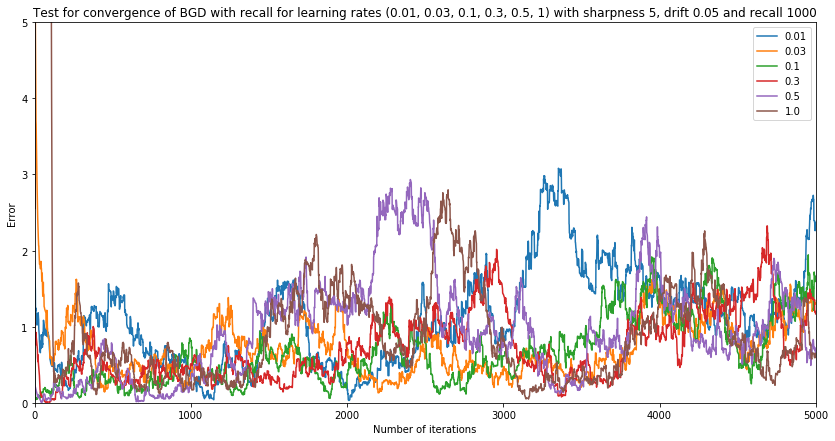

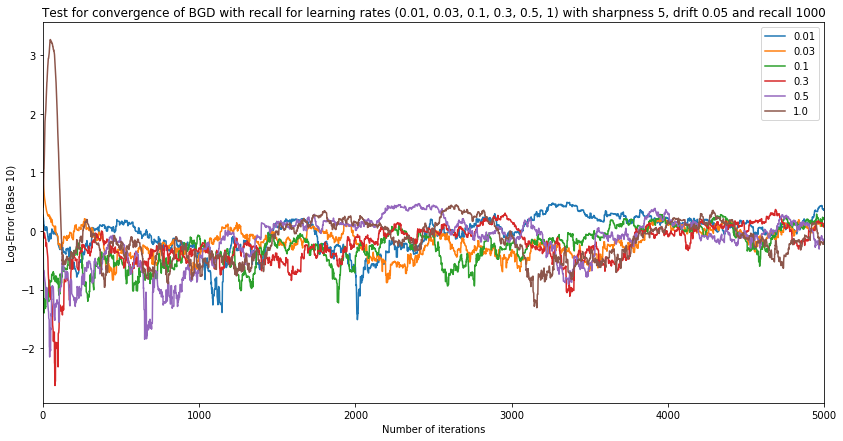

In [14]:
recall_test(1000)

Some notable conclusions can be drawn from experimentation:

- The learning rate at which divergent behaviour is observed has an inverse relationship with the number of independent variables.

- Higher learning rates increase rate of convergence, up to a point, but increase the frequency of unstable behaviour (partial or consistent divergence).

- Batch gradient is considerably more stable than stochastic gradient descent, and is preferred, however this significantly increases the cost of calculating each gradient update.

- The recall introduces a tradeoff between bias and variance; variance is lower with a higher recall but bias is higher since it converges to a least squares solution to a mixture of recent and old observations. This can be observed above when recall is 1000, the error tends to be much higher after a large number of iterations.

- In the recall tests, a high learning rate produces much more consistent convergence. This is because the variance of gradient update is is much lower when learning on a larger number of observations, so the direction of gradient update is likely to be an appropriate direction of update.